In [272]:
%load_ext autoreload
%autoreload 2
# %cd ..
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<!---
Latex Macros
-->
$$
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
$$

# Language Models
Language models (LMs) calculate the probability to see a given sequence of words, as defined through a [tokenization](todo) algorithm, in a given language or sub-language/domain/genre. For example, an English language model may assign a higher probability to seeing the sequence "How are you?" than to "Wassup' dawg?", and for a hip-hop language model this proportion may be reversed. <span class="summary">Language models (LMs) calculate the probability to see a given sequence of words.

There are several use cases for such models: 

* To filter out bad translations in machine translation.
* To rank speech recognition output. 
* In concept-to-text generation.

More formally, a language model is a stochastic process that models the probability \\(\prob(w_1,\ldots,w_d)\\) of observing sequences of words \\(w_1,\ldots,w_d\\). We can, without loss of generality, decompose the probability of such sequences into<span class="summary">Without loss of generality</span>  

$$
\prob(w_1,\ldots,w_d) = \prob(w_1) \prod_{i = 2}^d \prob(w_i|w_1,\ldots,w_{i-1}).
$$

This means that a language model can be defined by how it models the conditional probablity $\prob(w_i|w_1,\ldots,w_{i-1})$ of seeing a word \\(w_i\\) after having seen the *history* of previous words $w_1,\ldots,w_{i-1}$. We also have to model the prior probability $\prob(w_1)$, but it is easy to reduce this prior to a conditional probability as well.

In practice it is common to define language models based on *equivalence classes* of histories instead of having different conditional distributions for each possible history. This overcomes sparsity and efficiency problems when working with full histories.

## N-gram Language Models

The most common type of equivalence class relies on *truncating* histories $w_1,\ldots,w_{i-1}$ to length $n-1$:
$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \prob(w_i|w_{i-n},\ldots,w_{i-1}).
$$

That is, the probability of a word only depends on the last $n-1$ previous words. We will refer to such model as a *n-gram language model*.

## A Uniform Baseline LM

*Unigram* models are the simplest 1-gram language models. That is, they model the conditional probability of word using the prior probability of seeing that word:
$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \prob(w_i).
$$

To setup datasets and as baseline for more complex language models, we first introduce the simplest instantituation of a unigram model: a *uniform* language model which assigns the same prior probability to each word. That is, given a *vocabulary* of words \\(\vocab\\), the uniform LM is defined as:

$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \frac{1}{|\vocab|}.
$$

Let us "train" and test such a language model on the OHHLA corpus. First we need to load this corpus. Below we focus on a subset to make our code more responsive and to allow us to test models more quickly. Check the [loading from OHHLA](load_ohhla.ipynb) notebook to see how `load_albums` and `words` are defined. 

In [274]:
import statnlpbook.util as util
util.execute_notebook('load_ohhla.ipynb')
docs = load_albums(j_live)
trainDocs, testDocs = docs[:len(docs)//2], docs[len(docs)//2:] 
train = words(trainDocs)
test = words(testDocs)
" ".join(train[0:35])

"[BAR] Can ' t even call this a blues song [/BAR] [BAR] It ' s been so long [/BAR] [BAR] Neither one of us was wrong or anything like that [/BAR] [BAR] It seems like"

We can now create a uniform language model. Language models in this book implement the `LanguageModel` [abstract base class](https://docs.python.org/3/library/abc.html). 

In [ ]:
import abc 
class LanguageModel(metaclass=abc.ABCMeta):
    """
    Args:
        vocab: the vocabulary underlying this language model. Should be a set of words.
        order: history length (-1).
    """
    def __init__(self, vocab, order):
        self.vocab = vocab
        self.order = order
        
    @abc.abstractmethod
    def probability(self, word,*history):
        """
        Args:
            word: the word we need the probability of
            history: words to condition on.
        Returns:
            the probability p(w|history)
        """
        pass

The most important method we have to provide is `probability(word,history)` which returns the probability of a word given a history. Let us implement a uniform LM using this class.

In [129]:
class UniformLM(LanguageModel):
    def __init__(self, vocab):
        super().__init__(vocab, 1)
    def probability(self, word,*history):
        return 1.0 / len(self.vocab) if word in self.vocab else 0.0
    
vocab = set(train)
baseline = UniformLM(vocab)
baseline.probability("call")

0.0003912363067292645

## Sampling
It is instructive and easy to sample language from a language model. In many, but not all, cases the more natural the generated language of an LM looks, the better this LM is.

To sample from an LM one simply needs to iteratively sample from the LM conditional probability over words, and add newly sampled words to the next history. The only challenge in implementing this is to sample from a categorical distribution over words. Here we provide this functionality via `np.random.choice` from [numpy](http://www.numpy.org/). 

In [210]:
import numpy as np

def sample(lm, init, amount):
    words = list(lm.vocab)
    result = []
    result += init
    for _ in range(0, amount):
        history = result[-(lm.order-1):]
        probs = [lm.probability(word, *history) for word in words]
        sampled = np.random.choice(words,p=probs)
        result.append(sampled)
    return result

sample(baseline, [], 10)

['Bill',
 'gamblin',
 'Spit',
 'escape',
 'throughout',
 'Keith',
 'ample',
 '30-year-old',
 'sisters',
 'Band']

## Evaluation
How do we determine the quality of an (n-gram) LM? One way is through *extrinsic* evaluation: assess how much the LM improves performance on *downstream tasks* such as machine translation or speech recognition. Arguably this is the most important measure of LM quality, but it can be costly as re-training such systems may take days, and when we seek to develop general-purpose LMs we may have to evaluate performance on several tasks. This is problematic when one wants to iteratively improve LMs and test new models and parameters. It is hence useful to find *intrinsic* means of evaluation that assess the stand-alone quality of LMs with minimal overhead.

One intrinsic way is to measure how well the LM plays the "Shannon Game": Predict what the next word in actual context should be, and win if your predictions match the words in an actual corpus. This can be formalized  using the notion of *perplexity* of the LM on a given dataset. Given a test sequence \\(w_1,\ldots,w_T\\) of \\(T\\) words, we calculate the perplexity \\(\perplexity\\) as follows:

$$
\perplexity(w_1,\ldots,w_T) = \prob(w_1,\ldots,w_T)^{-\frac{1}{T}} = \sqrt[T]{\prod_i^T \frac{1}{\prob(w_i|w_{i-n},\ldots,w_{i-1})}}
$$

We can implement a perplexity function based on the `LanguageModel` interface. 

In [57]:
import math
def perplexity(lm, data):
    log_prob = 0.0
    history_order = lm.order - 1
    for i in range(history_order, len(data)):
        history = data[i - history_order : i]
        word = data[i]
        p = lm.probability(word, *history)
        log_prob += math.log(p) if p > 0.0 else float("-inf")
    return math.exp(-log_prob / (len(data) - history_order))

Let's see how the uniform model does on our test set. 

In [58]:
perplexity(baseline, test)  

inf

## Out-of-Vocabularly Words
The problem in the above example is that the baseline model assigns zero probability to words that are not in the vocabulary. Test sets will usually contain such words, and this leads to the above result of infinite perplexity. For example, the following three words do not appear in the training set vocabulary `vocab` and hence receive 0 probability.

In [63]:
[(w,baseline.probability(w)) for w in test if w not in vocab][:3]

[('send', 0.0), ('corrections', 0.0), ('typist', 0.0)]

## The Long Tail
The fact that we regularly encounter new words in our corpus is a common phenomenon not specific to our corpus. Generally we will see a few words that appear repeatedly, and a long tail of words that appear only a few times. While each individual long-tail word is rare, the probability of seeing any long-tail word is quite high (the long tail covers a lot of the frequency mass).

Let us observe this phenomenon for our data: we will rank the words according to their frequency, and plot this frequency against the rank. Let us first extracted the sorted counts and their ranks.

In [ ]:
import collections
counts = collections.defaultdict(int)
for word in train:
    counts[word] += 1
sorted_counts = sorted(counts.values(),reverse=True)
ranks = range(1,len(sorted_counts)+1)

We can now plot the counts against their rank. Play around with the x and y scale and change them to `'log'`.

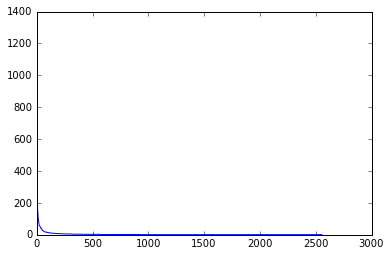

In [87]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.xscale('linear')
plt.yscale('linear')
plt.plot(ranks, sorted_counts)

In log-space such rank vs frequency graphs resemble linear functions. This observation is known as *Zipf's Law*, and can be formalized as follows. Let \\(r\_w\\) be the rank of a word \\(w\\), and \\(f\_w\\) its frequency, then we have:

$$
  f_w \propto \frac{1}{r_w}.
$$

## Inserting Out-of-Vocabularly Tokens
The long tail of infrequent words is a problem for LMs because it means there will always be words with zero counts in your training set. There are various solutions to this problem. For example, when it comes to calculating the LM perplexity we could remove words that do not appear in the training set. This overcomes the problem of infinite perplexity but doesn't solve the actual issue: the LM assigns too low probability to unseen words. Moreover, the problem only gets worse when one considers n-gram models with larger \\(n\\), because these will encounter many unseen n-grams, which, when removed, will only leave small fractions of the original sentences.

The principled solution to this problem is smoothing, and we will discuss it in more detail later. Before we get there we present a simple preprocessing step that generally simplifies the handling of unseen words, and gives rise to a simple smoothing heuristic. Namely, we replace unseen words in the test corpus with an out-of-vocabularly token, say `OOV`. This means that LMs can still work with a fixed vocabularly that consists of all training words, and the `OOV` token. Now we just need a way to estimate the probability of the `OOV` token to avoid the infinite perplexity problem.

In [90]:
OOV = '[OOV]'
def replace_OOVs(vocab,data):
    return [word if word in vocab else OOV for word in data]

replace_OOVs(baseline.vocab, test[:10])

['[BAR]',
 '[OOV]',
 '[OOV]',
 'to',
 'the',
 '[OOV]',
 '[/BAR]',
 '[BAR]',
 '[/BAR]',
 '[BAR]']

A simple way to (heuristically) estimate the `OOV` probability is to replace the first encounter of each word in the training set with the `OOV` token. Now we can estimate LMs as before, and will automatically get some estimate of the `OOV` probability. The underlying assumption of this heuristic is that the probability of unseen words is identical to the probability of encountering a new word. We illustrate the two operations of this method in the code below.

In [113]:
def inject_OOVs(data):
    seen = set()
    result = []
    for word in data:
        if word in seen:
            result.append(word)
        else:
            result.append(OOV)
            seen.add(word)
    return result

inject_OOVs(["AA","AA","BB","BB","AA"])

['[OOV]', 'AA', '[OOV]', 'BB', 'AA']

Now we can apply this to our training and test set, and create a new uniform model.

In [133]:
oov_train = inject_OOVs(train)
oov_vocab = set(oov_train)
oov_test = replace_OOVs(oov_vocab, test)
oov_baseline = UniformLM(oov_vocab)
perplexity(oov_baseline,oov_test) 

928.0000000011556

## Training Language Models
The uniform LM is obviously not good at modelling actual language. To improve upon this baseline, we can estimate the conditional n-gram distributions from the training data. To this end let us first introduce one parameter $\param_{w,h}$ for each word $w$ and history $h$ of length $n - 1$, and define a parametrized language model $p_\params$: 

$$
\prob_\params(w|h) = \param_{w,h}
$$

Training an n-gram LM amounts to estimating \\(\params\\) from some training set \\(\train=(w_1,\ldots,w_n)\\).
One way to do this is to choose the \\(\params\\) that maximizes the log-likelihood of \\(\train\\):
$$
\params^* = \argmax_\params \log p_\params(\train)
$$

As it turns out, this maximum-log-likelihood estimate (MLE) can calculated in closed form, simply by counting:
$$
\param^*_{w,h} = \frac{\counts{\train}{h,w}}{\counts{\train}{h}} 
$$

where 

$$
\counts{D}{e} = \text{Count of } e \text{ in }  D 
$$

Many LM variants can be implemented simply by estimating the counts in the nominator and denominator differently. We therefore introduce an interface for such count-based LMs. This will help us later to implement LM variants by modifying the counts of a base-LM. 

In [245]:
class CountLM(LanguageModel):
    """
    A Language Model that uses counts of events and histories to calculate probabilities of words in context.
    """
    @abc.abstractmethod
    def counts(self, word_and_history):
        pass
    @abc.abstractmethod
    def norm(self, history):
        pass
    
    def probability(self, word, *history):
        sub_history = tuple(history[-(self.order-1):]) if self.order > 1 else () 
        return self.counts((word,) + sub_history) / self.norm(sub_history)


Let us use this to code up a generic NGram model.

In [246]:
class NGramLM(CountLM):
    def __init__(self, train, order):
        """
        Create an NGram language model.
        Args:
            train: list of training tokens.
            order: order of the LM.
        """
        super().__init__(set(train), order)
        self._counts = collections.defaultdict(float)
        self._norm = collections.defaultdict(float)
        for i in range(self.order, len(train)):
            history = tuple(train[i - self.order + 1 : i])
            word = train[i]
            self._counts[(word,) + history] += 1.0
            self._norm[history] += 1.0
    def counts(self, word_and_history):
        return self._counts[word_and_history]
    def norm(self, history):
        return self._norm[history]

Let us train a unigram model.  

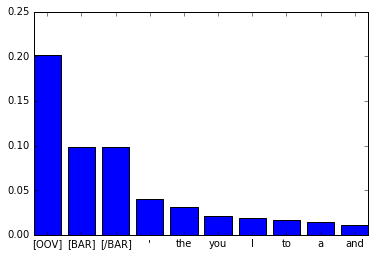

In [257]:
unigram = NGramLM(oov_train,1)
def plot_probabilities(lm, context = (), how_many = 10):    
    probs = sorted([(word,lm.probability(word,*context)) for word in lm.vocab], key=lambda x:x[1], reverse=True)[:how_many]
    plt.xticks(range(0,len(probs)),[word for word, _ in probs])
    plt.bar(range(0,len(probs)),[prob for _,prob in probs],align='center')
plot_probabilities(unigram)

The unigram LM has substantially reduced (and hence better) perplexity:

In [248]:
perplexity(unigram,oov_test) 

78.11302463241343

Let us also look at the language the unigram LM generates.

In [249]:
sample(unigram, [], 10)

['get', 'is', "'", 'was', 'It', 'on', 'with', 'man', 'that', 'in']

## Bigram LM

The unigram model ignores any correlation between consecutive words in a sentence. The next best model to overcome this shortcoming is a bigram model. This model conditions the probability of the current word on the previous word. Let us construct such model from the training data. 



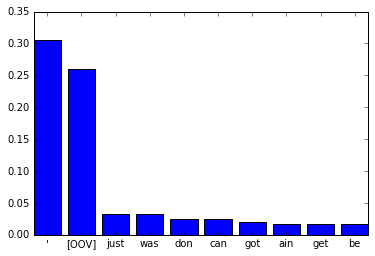

In [260]:
bigram = NGramLM(oov_train,2)
probs = sorted([(word,bigram.probability(word, "I")) for word in bigram.vocab], key=lambda x:x[1], reverse=True)[:10]
plot_probabilities(bigram, ('I',))

You can see a more peaked distribution conditioned on "I" than in the case of the unigram model. Let us see how the bigram LM generates language.

In [267]:
" ".join(sample(bigram, ['[BAR]'], 30))

"[BAR] She said nigga please don ' s love of a voice said Shit I [OOV] ' t play [/BAR] [BAR] [OOV] [OOV] [OOV] now [OOV] your own flow so damn"

Does the bigram model improve perplexity?

In [269]:
perplexity(bigram,oov_test) 

inf

Unfortunately the bigram model has the problem we tried to avoid using the OOV preprocessing method above. The problem is that there are contexts in which the OOV word (and other words) hasn't been seen, and hence it receives 0 probability.

In [271]:
bigram.probability("[OOV]","money") 

0.0

## Smoothing

The general problem is that maximum likelhood estimates will always underestimate the true probability of some words, and in turn overestimate the (context-dependent) probabilities of other words. To overcome this issue we aim to _smooth_ the probabilities and move mass from seen events to unseen events.

### Laplace Smoothing

The easiest way to overcome the problem of zero probabilities is to simply add pseudo counts to each event in the dataset (in a Bayesian setting this amounts to a maximum posteriori estimate under a dirichlet prior on parameters).

$$
\param^{\alpha}_{w,h} = \frac{\counts{\train}{h,w} + \alpha}{\counts{\train}{h} + \alpha \lvert V \rvert } 
$$

Let us implement this in Python.

In [286]:
class LaplaceLM(CountLM):
    def __init__(self, base_lm, alpha):
        super().__init__(base_lm.vocab, base_lm.order)
        self.base_lm = base_lm
        self.alpha = alpha
    def counts(self, word_and_history):
        return self.base_lm.counts(word_and_history) + self.alpha
    def norm(self, history):
        return self.base_lm.norm(history) + self.alpha * len(self.base_lm.vocab)

laplace_bigram = LaplaceLM(bigram, 0.1) 
laplace_bigram.probability("[OOV]","money")

0.0010660980810234541

This should give a better perplexity value:

In [287]:
perplexity(laplace_bigram,oov_test) 

59.51634219903197

### Adjusted counts
It is often useful to think of smoothing algorithms as un-smoothed Maximum-Likelhood estimators that work with *adjusted* n-gram counts in the numerator, and fixed history counts in the denominator. This allows us to see how counts from high-frequency words are reduced, and counts of unseen words increased. If these changes are too big, the smoothing method is likely not very effective.

Let us reformulate the laplace LM using adjusted counts. Note that we since we have histories with count 0, we do need to increase the original denominator by a small \\(\epsilon\\) to avoid division by zero. 
$$
\begin{split}
\counts{\train,\alpha}{h,w} &= \param^{\alpha}_{w,h} \cdot (\counts{\train}{h} +  \epsilon)\\\\
\counts{\train,\alpha}{h} &= \counts{\train}{h} + \epsilon
\end{split}
$$

In [338]:
class AdjustedLaplaceLM(CountLM):
    def __init__(self, base_lm, alpha):
        super().__init__(base_lm.vocab, base_lm.order)
        self.base_lm = base_lm
        self.alpha = alpha
        self.eps = 0.000001
    def counts(self, word_and_history):
        history = word_and_history[1:]
        word = word_and_history[0]
        return 0.0 if word not in self.vocab else \
               (self.base_lm.counts(word_and_history) + self.alpha) / \
               (self.base_lm.norm(history) + self.alpha * len(self.base_lm.vocab)) * \
               (self.base_lm.norm(history) + self.eps)
    def norm(self, history):
        return self.base_lm.norm(history) + self.eps

adjusted_laplace_bigram = AdjustedLaplaceLM(bigram, 0.1)
bigram.counts((OOV,OOV)), adjusted_laplace_bigram.counts((OOV,OOV))

(585.0, 564.5934362811013)

We see above that for high frequency words the absolute counts are altered quite substantially. This is unfortunate because for high frequency words we would expect the counts to be relatively accurate. Can we test more generally wether our adjusted counts are sensible?

One option is to compare the adjusted counts to average counts in a held-out set. For example, for words of count 0 in the training set, how does their average count in the held-out set compare to their adjusted count in the smoothed model? To test this we need some helper functions.

In [ ]:
def cross_product(lists):
    """
    Returns a generator over all tuples in the cross product of the lists in `lists`.
    Args:
        lists: a list of lists
    Returns:
        generator that generates all tuples in the cross product.
    """
    if len(lists) == 0:
        yield ()
    else:
        for prev_tuple in cross_product(lists[1:]):
            for head in lists[0]:
                yield (head,) + prev_tuple

def avg_counts(train_lm, test_lm, vocab):
    """
    Calculate a dictionary from counts in the training-LM to counts in the test-LM. 
    """
    avg_test_counts = collections.defaultdict(float)
    norm = collections.defaultdict(float)
    for ngram in cross_product([list(train_lm.vocab)] * train_lm.order):
        train_count = train_lm.counts(ngram)
        test_count = test_lm.counts(ngram)
        avg_test_counts[train_count] += test_count
        norm[train_count] += 1.0
    for c in avg_test_counts.keys():
        avg_test_counts[c] /= norm[c]
    return avg_test_counts

We can now calculate a table of training counts, test counts, and smoothed counts.

In [322]:
test_bigram = NGramLM(oov_test, 2)
joint_vocab = set(oov_test + oov_train)
avg_test_counts = avg_counts(bigram, test_bigram, joint_vocab)
avg_laplace_counts = avg_counts(bigram, AdjustedLaplaceLM(bigram, 0.1), joint_vocab)
for count in range(0, 6):
    print("{} {:10.4f} {:10.4f}".format(count, avg_test_counts[count], avg_laplace_counts[count]))

0     0.0041     0.0096
1     0.4125     0.1986
2     1.0836     0.4627
3     1.7626     0.6324
4     2.9123     0.9495
5     3.6724     1.0867


### Interpolation
For a given context the smoothing methods discussed above shift mass uniformly across the words that haven't been seen in this context. This makes sense when the words are not in the vocabularly. However, when words are in the vocabularly but just have not been seen in the given context, we can do better because we can leverage statistics about the word from other contexts. In particular, we can *back-off* to the statistics of \\(n-1\\) grams. 


In [389]:
adjusted_laplace_bigram.probability('skies','skies'), adjusted_laplace_bigram.probability('[/BAR]','skies')

(0.0010548523206751054, 0.0010548523206751054)

A simple technique to use the \\(n-1\\) gram statistics is interpolation. Here we  compose the probability of a word as the weighted sum of the probability of an \\(n\\)-gram model \\(p'\\) and a back-off \\(n-1\\) model \\(p''\\): 

$$
\prob_{\alpha}(w_i|w_{i-n},\ldots,w_{i-1}) = \alpha \cdot \prob'(w_i|w_{i-n},\ldots,w_{i-1}) + (1 - \alpha) \cdot \prob''(w_i|w_{i-n+1},\ldots,w_{i-1})
$$

A Python implementation of this model can be seen below. We also show how a more likely unigram now has a higher probability in a context it hasn't seen in before. 

In [404]:
class InterpolatedLM(LanguageModel):
    def __init__(self, main, backoff, alpha):
        super().__init__(main.vocab, main.order)
        self.main = main
        self.backoff = backoff
        self.alpha = alpha
    def probability(self, word, *history):
        return self.alpha * self.main.probability(word,*history) + \
               (1.0 - self.alpha) * self.backoff.probability(word,*history)

interpolated = InterpolatedLM(adjusted_laplace_bigram,unigram,0.01)
interpolated.probability('skies','skies'), interpolated.probability('[/BAR]','skies')

(0.0001662701118815446, 0.09764798462230231)

We can now find a good $\alpha$ parameter to optimise for perplexity. Notice that in practice this should be done using a development set.

In [ ]:
alphas = np.arange(0,1.1,0.1)
perplexities = [perplexity(InterpolatedLM(adjusted_laplace_bigram,unigram,alpha),oov_test) for alpha in alphas]
plt.plot(alphas,perplexities)

### Backoff 
Instead of combining probabilities for all words given a context, it makes sense to back-off only when no counts for a given event are available and rely on available counts where possible. 

<div class="newslide"></div>
A particularly simple, if not to say stupid, backoff method is [Stupid Backoff](http://www.aclweb.org/anthology/D07-1090.pdf). Let \\(w\\) be a word and \\(h_{n}\\) be an n-gram of length \\(n\\):  

$$
\prob_{\mbox{Stupid}}(w|h_n) = 
\begin{cases}
\frac{\counts{\train}{h_n,w}}{\counts{\train}{h_n}}  &= \mbox{if }\counts{\train}{h_n,w} > 0 \\\\
\prob_{\mbox{Stupid}}(w|h_{n-1}) & \mbox{otherwise}
\end{cases}
$$

In [414]:
class StupidBackoff(LanguageModel):
    def __init__(self, main, backoff, alpha):
        super().__init__(main.vocab, main.order)
        self.main = main
        self.backoff = backoff
        self.alpha = alpha
    def probability(self, word, *history):
        return self.main.probability(word,*history) \
          if self.main.counts((word,)+tuple(history)) > 0 \
          else self.alpha * self.backoff.probability(word,*history)


It turns out that the Stupid LM is very effective when it comes to *extrinsic* evaluations, but it doesn't represent a valid probability distribution: when you sum over the probabilities of all words given a history, the result may be larger than 1. This is the case because the main n-gram model probabilities for all non-zero count words already sum to 1. The fact that the probabilities sum to more than 1 makes perplexity values meaningless. The code below illustrates the problem.

In [420]:
# val stupid = StupidBackoff(bigram,unigram, 0.1)
# stupid.vocab.toSeq.map(w => stupid.probability(w, "the")).sum 
stupid = StupidBackoff(bigram, unigram, 0.1)
sum([stupid.probability(word, 'the') for word in stupid.vocab])

1.0711443177349667

The are several "proper backoff models" that do not have this problem, e.g. the Katz-Backoff method. We refer to other material below for a deeper discussion of these.

### Background Reading

* Jurafsky & Martin, Speech and Language Processing: Chapter 4, N-Grams.
* Bill MacCartney, Stanford NLP Lunch Tutorial: [Smoothing](http://nlp.stanford.edu/~wcmac/papers/20050421-smoothing-tutorial.pdf)